In [1]:
%%html
<style>
.output_subarea.output_text.output_stream.output_stdout > pre {
    width:max-content;
}
.p-Widget.jp-RenderedText.jp-OutputArea-output > pre {
   width:max-content;
}
</style>

In [2]:
import html
import visualize

In [3]:
import pandas as pd
import sys
#sys.path.insert(0, '..')
sys.path.append('..')
pd.set_option('display.max_columns', 10000000)
pd.set_option('display.max_rows', 10000000)
pd.set_option('display.width', 10000000)

In [4]:
import visualize
from com.ophelia.OpheliaVendata import OpheliaVendata

In [5]:
ophelia = OpheliaVendata()


14:34:49.093 Ophelia [INFO] ¡Hi! My name is Ophelia
14:34:49.093 Ophelia [INFO] I am an artificial assistant for machine learning applications in Spark
14:34:49.093 Ophelia [INFO] Welcome to Ophelia Assisted Intelligence System (OAIS)
14:34:49.093 Ophelia [INFO] V for Vendata...

                                 - By. Vendata-Gentleman Club -                            

                   █ █ █ █ █ █ █ █ █ █ █ █ █ █ █ █ █ █ █ █ █ █ █ █ █ █ █ █ █ █ █
                   █ █ █ █ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ █ █ █ █
                   █ █ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ █ █
                   █ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ █
                   █ ╬ ╬ ╬ █ █ █ █ █ █ █ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ █ █ █ █ █ █ █ ╬ ╬ ╬ █
                   █ ╬ ╬ █ █ ╬ ╬ ╬ ╬ █ █ █ ╬ ╬ ╬ ╬ ╬ ╬ ╬ █ █ █ ╬ ╬ ╬ ╬ █ █ ╬ ╬ █
                   █ ╬ █ █ ╬ ╬ ╬ ╬ ╬ ╬ ╬ █ █ ╬ ╬ ╬ ╬ ╬ █ █ ╬ ╬ ╬ ╬ ╬ ╬ ╬ █ █ ╬ █
                   █ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬ ╬

In [7]:
spark = ophelia.ophelia_session
path = "data/ophelia/out/model/RiskClassifier/"
customer_banking = ophelia.ophelia_read.read_file(spark, path, "parquet")

14:36:10.898 Ophelia [INFO] Read Parquet File
14:36:13.762 Ophelia [INFO] Read Parquet Successfully From Path: data/ophelia/out/model/RiskClassifier/


In [5]:
customer_banking.show(5)

+---+-----------+-------+---------+------+-----+------+-------+------+----------+
|age|        job|marital|education|gender|child|saving|insight|backup|risk_label|
+---+-----------+-------+---------+------+-----+------+-------+------+----------+
| 54|     admin.|married| tertiary|female|    1|     0|      0|     1|        MA|
| 28|   services| single|secondary|female|    0|     0|      0|     1|        MA|
| 28|blue-collar| single|secondary|female|    1|     0|      1|     0|        MA|
| 52| management|married|  unknown|female|    0|     1|      1|     0|        MA|
| 48|blue-collar|married|secondary|female|    0|     1|      1|     0|        MA|
+---+-----------+-------+---------+------+-----+------+-------+------+----------+
only showing top 5 rows



## Se ha decidido aplicar el algoritmo Gradient-Boosted Tree Classifier, la rezón es por tener el potenciador del gradiente descendente, este ha demostrado tener buenos resultados, dado que el algoritmo no soporta clasificación multiclass, se trabajará un tratamiento especial a los datos.

## Se crearán 5 GBTClassifier, uno para cada clase de riesgo {'A', 'MA', 'M', 'MC', 'C'}, convertiremos la clase $k_{i}$ en 1 y el resto en cero.

In [8]:
import numpy as np

from pyspark.sql import DataFrame
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.sql.functions import when, col, lit

In [9]:
initial_string_columns = [
    "job",
    "marital",
    "education",
    "gender"
]
cast_numeric_columns = [
    col("age").cast("float"),
    col("child").cast("float"),
    col("saving").cast("float"),
    col("insight").cast("float"),
    col("backup").cast("float")
]
build_target = when(col("risk_label") == "C", lit(1.0)).otherwise(0.0)
mapped_classes = customer_banking.select(
    *initial_string_columns,
    *cast_numeric_columns,
    build_target.alias("label")
)
mapped_classes.show(5, False)
mapped_classes.printSchema()

+----------+-------+---------+------+----+-----+------+-------+------+-----+
|job       |marital|education|gender|age |child|saving|insight|backup|label|
+----------+-------+---------+------+----+-----+------+-------+------+-----+
|admin.    |married|secondary|female|59.0|0.0  |1.0   |0.0    |1.0   |0.0  |
|admin.    |married|secondary|female|56.0|1.0  |0.0   |1.0    |0.0   |0.0  |
|technician|married|secondary|male  |41.0|1.0  |0.0   |1.0    |1.0   |0.0  |
|services  |married|secondary|male  |55.0|0.0  |1.0   |0.0    |0.0   |0.0  |
|admin.    |married|tertiary |female|54.0|0.0  |1.0   |1.0    |0.0   |0.0  |
+----------+-------+---------+------+----+-----+------+-------+------+-----+
only showing top 5 rows

root
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: float (nullable = true)
 |-- child: float (nullable = true)
 |-- saving: float (nullable = true)
 |-- insight: flo

## Bitácora de experimentos:
- para el primer experimento, entrenamos un modelo Gradient Boosted Tree Classifier prediciendo la clase 'C' (conservador) como variable 'target' = 1, la distribución es de [1:526, 0:10636], la clase 1 (positiva) presenta desbalanceo 20:1, observaremos los resultado producidos con el modelo defacto a entrenar.

In [10]:
negative_class = mapped_classes.groupBy("label").count().where(col("label") == 0.0).select("count").collect()[0][0]
positive_class = mapped_classes.groupBy("label").count().where(col("label") == 1.0).select("count").collect()[0][0]

print("Class proportion", str(round(negative_class/positive_class)) + ":1")

Class proportion 13:1


In [11]:
def pipe(transform_list):
    return Pipeline(stages=transform_list)

def fit(pipe, df):
    return pipe.fit(df)

def transform(model, df):
    return model.transform(df)

In [12]:
def string_indexer(col_list):
    return [StringIndexer(inputCol=column, outputCol="{0}_index".format(column)) for column in col_list]

def build_string_index(df, col_list):
    indexers = string_indexer(col_list)
    pipe = pipe(indexers)
    fit_model = fit(pipe, df)
    return transform(fit_model, df)

In [24]:
a = []
if a is list:
    print("hola")

In [17]:
from typing import List

In [18]:
def single_string_indexer(single_col: str) -> StringIndexer:
    return StringIndexer(inputCol=single_col, outputCol=single_col + "_index")

def multi_string_indexer(multi_col: list) -> List[StringIndexer]:
    indexer = [StringIndexer(
        inputCol=column,
        outputCol="{0}_index".format(column)) for column in multi_col]
    return indexer

In [19]:
def build_string_index(df: DataFrame, indexer_type: str, col_name: str = None, col_list: list = None) -> DataFrame:
    dict_indexer = {
        "single": single_string_indexer,
        "multi": multi_string_indexer
    }
    if col_list is not None:
        pipe_ml = pipe(dict_indexer[indexer_type](col_list))
    elif col_name is not None:
        pipe_ml = pipe(dict_indexer[indexer_type](col_name))
    else:
        raise ValueError('Unexpected indexer type:{}'.format(dict_indexer[indexer_type]))
    fit_model = fit(pipe_ml, df)
    return transform(fit_model, df)

In [20]:
categorical_columns = ['job', 'marital', 'education', 'gender']

In [21]:
transform_df = build_string_index(df=mapped_classes, indexer_type="multi", col_name=categorical_columns)
transform_df.show(5, False)
transform_df.printSchema()

+----------+-------+---------+------+----+-----+------+-------+------+-----+---------+-------------+---------------+------------+
|job       |marital|education|gender|age |child|saving|insight|backup|label|job_index|marital_index|education_index|gender_index|
+----------+-------+---------+------+----+-----+------+-------+------+-----+---------+-------------+---------------+------------+
|admin.    |married|secondary|female|59.0|0.0  |1.0   |0.0    |1.0   |0.0  |3.0      |0.0          |0.0            |1.0         |
|admin.    |married|secondary|female|56.0|1.0  |0.0   |1.0    |0.0   |0.0  |3.0      |0.0          |0.0            |1.0         |
|technician|married|secondary|male  |41.0|1.0  |0.0   |1.0    |1.0   |0.0  |2.0      |0.0          |0.0            |0.0         |
|services  |married|secondary|male  |55.0|0.0  |1.0   |0.0    |0.0   |0.0  |4.0      |0.0          |0.0            |0.0         |
|admin.    |married|tertiary |female|54.0|0.0  |1.0   |1.0    |0.0   |0.0  |3.0      |0.0 

In [206]:
from pyspark.ml.feature import Binarizer, BucketedRandomProjectionLSH, BucketedRandomProjectionLSHModel, Bucketizer, \
    ChiSqSelector, ChiSqSelectorModel, CountVectorizer, CountVectorizerModel, DCT, ElementwiseProduct, FeatureHasher, \
    HashingTF, IDF, IDFModel, Imputer, ImputerModel, IndexToString, MaxAbsScaler, MaxAbsScalerModel, MinHashLSH, \
    MinHashLSHModel, MinMaxScaler, MinMaxScalerModel, NGram, Normalizer, OneHotEncoder, \
    OneHotEncoderModel, PCA, PCAModel, PolynomialExpansion, QuantileDiscretizer, RegexTokenizer, RFormula, \
    RFormulaModel, StringIndexer, StringIndexerModel, VectorSlicer, Word2Vec, VectorSizeHint, StopWordsRemover, \
    StandardScalerModel, StandardScaler, SQLTransformer, Tokenizer, VectorAssembler, VectorIndexer, VectorIndexerModel, \
    Word2VecModel


class OpheliaJavaTransformers:

    __all__ = [Binarizer, BucketedRandomProjectionLSH, BucketedRandomProjectionLSHModel,
               Bucketizer, ChiSqSelector, ChiSqSelectorModel, CountVectorizer, CountVectorizerModel,
               DCT, ElementwiseProduct, FeatureHasher, HashingTF, IDF, IDFModel, Imputer, ImputerModel,
               IndexToString, MaxAbsScaler, MaxAbsScalerModel, MinHashLSH, MinHashLSHModel, MinMaxScaler,
               MinMaxScalerModel, NGram, Normalizer, OneHotEncoder, OneHotEncoderModel,
               PCA, PCAModel, PolynomialExpansion, QuantileDiscretizer, RegexTokenizer, RFormula, RFormulaModel,
               SQLTransformer, StandardScaler, StandardScalerModel, StopWordsRemover, StringIndexer, StringIndexerModel,
               Tokenizer, VectorAssembler, VectorIndexer, VectorIndexerModel, VectorSizeHint, VectorSlicer, Word2Vec,
               Word2VecModel]

In [207]:
def class_type(dtype):
    return dtype.__class__

def class_name(dtype):
    return dtype.__class__.__name__

In [208]:
def fit(pipe, df: DataFrame):
    if class_type(pipe) not in OpheliaJavaTransformers.__all__:
        raise TypeError("'pipe' must be OpheliaMLObjects not " + class_name(pipe))
    return pipe.fit(df)

In [209]:
def ohe_estimator(col_list):
    indexers = string_indexer(col_list)
    encoder = OneHotEncoder(
        inputCols=[indexer.getOutputCol() for indexer in indexers],
        outputCols=["{0}_encoded".format(indexer.getOutputCol()) for indexer in indexers]
    )
    return encoder

def build_one_hot_encoder(df, col_list):
    encoder = ohe_estimator(col_list)
    encode_vector = fit(encoder, df)
    return transform(encode_vector, df)

In [210]:
columns_lambda = lambda k: k.endswith('_index')
indexed_columns = list(filter(columns_lambda, transform_df.columns))
encode_vector_df = build_one_hot_encoder(transform_df, categorical_columns).drop(*indexed_columns)
encode_vector_df.show(5)

+-----------+-------+---------+------+----+-----+------+-------+------+-----+-----------------+---------------------+-----------------------+--------------------+
|        job|marital|education|gender| age|child|saving|insight|backup|label|job_index_encoded|marital_index_encoded|education_index_encoded|gender_index_encoded|
+-----------+-------+---------+------+----+-----+------+-------+------+-----+-----------------+---------------------+-----------------------+--------------------+
|     admin.|married| tertiary|female|54.0|  1.0|   0.0|    0.0|   1.0|  0.0|   (11,[3],[1.0])|        (2,[0],[1.0])|          (3,[1],[1.0])|       (1,[0],[1.0])|
|   services| single|secondary|female|28.0|  0.0|   0.0|    0.0|   1.0|  0.0|   (11,[4],[1.0])|        (2,[1],[1.0])|          (3,[0],[1.0])|       (1,[0],[1.0])|
|blue-collar| single|secondary|female|28.0|  1.0|   0.0|    1.0|   0.0|  0.0|   (11,[1],[1.0])|        (2,[1],[1.0])|          (3,[0],[1.0])|       (1,[0],[1.0])|
| management|married| 

In [211]:
def indexer_encoded(index_list):
    indexers = string_indexer(index_list)
    encode_index_list = []
    for c in range(len(indexers)):
        encode_index_list.append(indexers[c].getOutputCol() + "_encoded")
    return encode_index_list

In [212]:
indexers = string_indexer(categorical_columns)
string_indexer_cols = []
for c in range(len(indexers)):
    string_indexer_cols.append(indexers[c].getOutputCol() + "_encoded")

In [213]:
string_indexer_cols

['job_index_encoded',
 'marital_index_encoded',
 'education_index_encoded',
 'gender_index_encoded']

In [214]:
numericCols = ['age', 'child', 'saving', 'insight', 'backup']
assemblerInputs = string_indexer_cols + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

In [215]:
assemble_model = assembler.transform(encode_vector_df)
assemble_model.show(5, False)

+-----------+-------+---------+------+----+-----+------+-------+------+-----+-----------------+---------------------+-----------------------+--------------------+---------------------------------------------------------+
|job        |marital|education|gender|age |child|saving|insight|backup|label|job_index_encoded|marital_index_encoded|education_index_encoded|gender_index_encoded|features                                                 |
+-----------+-------+---------+------+----+-----+------+-------+------+-----+-----------------+---------------------+-----------------------+--------------------+---------------------------------------------------------+
|admin.     |married|tertiary |female|54.0|1.0  |0.0   |0.0    |1.0   |0.0  |(11,[3],[1.0])   |(2,[0],[1.0])        |(3,[1],[1.0])          |(1,[0],[1.0])       |(22,[3,11,14,16,17,18,21],[1.0,1.0,1.0,1.0,54.0,1.0,1.0])|
|services   |single |secondary|female|28.0|0.0  |0.0   |0.0    |1.0   |0.0  |(11,[4],[1.0])   |(2,[1],[1.0])        

In [216]:
cols = mapped_classes.columns
selectedCols = cols + ['features']
vectorized_customer_banking = assemble_model.select(selectedCols)

In [217]:
vectorized_customer_banking.show(5, False)

+-----------+-------+---------+------+----+-----+------+-------+------+-----+---------------------------------------------------------+
|job        |marital|education|gender|age |child|saving|insight|backup|label|features                                                 |
+-----------+-------+---------+------+----+-----+------+-------+------+-----+---------------------------------------------------------+
|admin.     |married|tertiary |female|54.0|1.0  |0.0   |0.0    |1.0   |0.0  |(22,[3,11,14,16,17,18,21],[1.0,1.0,1.0,1.0,54.0,1.0,1.0])|
|services   |single |secondary|female|28.0|0.0  |0.0   |0.0    |1.0   |0.0  |(22,[4,12,13,16,17,21],[1.0,1.0,1.0,1.0,28.0,1.0])       |
|blue-collar|single |secondary|female|28.0|1.0  |0.0   |1.0    |0.0   |0.0  |(22,[1,12,13,16,17,18,20],[1.0,1.0,1.0,1.0,28.0,1.0,1.0])|
|management |married|unknown  |female|52.0|0.0  |1.0   |1.0    |0.0   |0.0  |(22,[0,11,16,17,19,20],[1.0,1.0,1.0,52.0,1.0,1.0])       |
|blue-collar|married|secondary|female|48.0|0.0  

In [220]:
train, test = vectorized_customer_banking.randomSplit([0.7, 0.3], seed = 2020)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

print("\nTrain distribution label")
train.groupBy("label").count().show()

print("Test distribution label")
test.groupBy("label").count().show()

Training Dataset Count: 7862
Test Dataset Count: 3300

Train distribution label
+-----+-----+
|label|count|
+-----+-----+
|  0.0| 7477|
|  1.0|  385|
+-----+-----+

Test distribution label
+-----+-----+
|label|count|
+-----+-----+
|  0.0| 3159|
|  1.0|  141|
+-----+-----+



## Logistic Regression Model

In [221]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol='features', labelCol='label', maxIter=10)
lrModel = lr.fit(train)

In [222]:
class_type(lrModel)

pyspark.ml.classification.LogisticRegressionModel

In [223]:
class_name(lrModel)

'LogisticRegressionModel'

In [224]:
def plot_summary(model):
    beta = np.sort(model.coefficientMatrix)
    plt.plot(beta)
    plt.ylabel('Beta Coefficients')
    plt.show()

In [225]:
lrModel.coefficientMatrix

DenseMatrix(1, 22, [-3.8223, -4.2224, -3.925, -3.7697, -3.5314, 2.4186, -3.8035, -3.2811, ..., -3.4318, -3.6408, -1.3105, 0.1249, -1.0193, -1.034, -0.5314, -0.9967], 1)

In [226]:
lrModel.coefficients

DenseVector([-3.8223, -4.2224, -3.925, -3.7697, -3.5314, 2.4186, -3.8035, -3.2811, 2.9953, -3.9444, -4.8353, -0.3106, 2.2887, -3.7233, -3.4318, -3.6408, -1.3105, 0.1249, -1.0193, -1.034, -0.5314, -0.9967])

In [227]:
lrModel.elasticNetParam

Param(parent='LogisticRegression_7d1dc03d1084', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.')

In [228]:
lrModel.intercept

-4.42865775731924

In [229]:
lrModel.interceptVector

DenseVector([-4.4287])

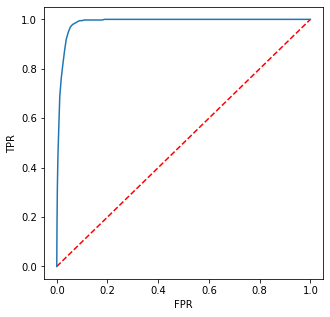

In [230]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(lrModel.summary.roc.select('FPR').collect(),
         lrModel.summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [231]:
lrModel.summary.roc.show(5, False)

+---------------------+-------------------+
|FPR                  |TPR                |
+---------------------+-------------------+
|0.0                  |0.0                |
|9.362043600374481E-4 |0.16103896103896104|
|0.0024073826400962954|0.3194805194805195 |
|0.004814765280192591 |0.45454545454545453|
|0.008292095760331684 |0.5714285714285714 |
+---------------------+-------------------+
only showing top 5 rows



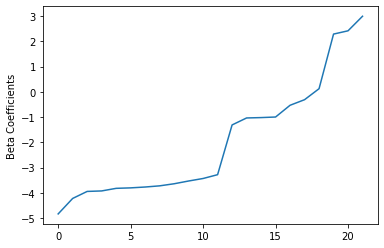

In [232]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

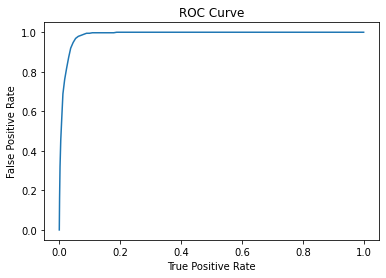

Training set areaUnderROC: 0.9871203291826536


In [233]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

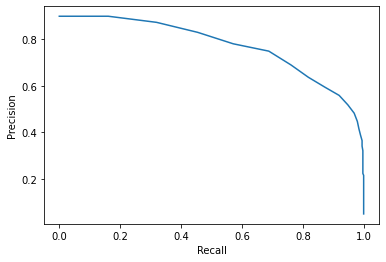

In [234]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [235]:
mapped_classes.columns

['job',
 'marital',
 'education',
 'gender',
 'age',
 'child',
 'saving',
 'insight',
 'backup',
 'label']

In [236]:
test.printSchema()

root
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: float (nullable = true)
 |-- child: float (nullable = true)
 |-- saving: float (nullable = true)
 |-- insight: float (nullable = true)
 |-- backup: float (nullable = true)
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)



In [237]:
predict_cols = mapped_classes.columns + ['prediction', 'probability', 'rawPrediction']
predictions = lrModel.transform(test)
predictions.select(*predict_cols).where(col("label") == 1.0).show(20, False)

+----------+--------+---------+------+----+-----+------+-------+------+-----+----------+-----------------------------------------+------------------------------------------+
|job       |marital |education|gender|age |child|saving|insight|backup|label|prediction|probability                              |rawPrediction                             |
+----------+--------+---------+------+----+-----+------+-------+------+-----+----------+-----------------------------------------+------------------------------------------+
|retired   |divorced|primary  |female|90.0|1.0  |0.0   |0.0    |0.0   |1.0  |1.0       |[0.03692388070218996,0.9630761192978101] |[-3.261273937376176,3.261273937376176]    |
|retired   |divorced|primary  |male  |67.0|1.0  |1.0   |0.0    |0.0   |1.0  |1.0       |[0.3396556122936356,0.6603443877063645]  |[-0.6648292992289893,0.6648292992289893]  |
|retired   |divorced|primary  |male  |95.0|1.0  |1.0   |1.0    |0.0   |1.0  |1.0       |[0.025806130912177688,0.9741938690878224]|

In [238]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.9883716231233961


In [ ]:
import numpy as np

from typing import Any
from pyspark.sql import DataFrame
from pyspark.ml.linalg import DenseVector, DenseMatrix
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel, \
    BinaryLogisticRegressionTrainingSummary

def __build_parameters_model(**kargs: Any) -> dict:
        
    features_col = str(kargs.get("featuresCol"))
    label_col = str(kargs.get("labelCol"))
    max_iter = int(kargs.get("maxIter"))
    prediction_col = str(kargs.get("predictionCol"))
    reg_param = float(kargs.get("regParam"))
    elastic_net_param = float(kargs.get("elasticNetParam"))
    tolerance = float(kargs.get("tol"))
    fit_intercept = bool(kargs.get("fitIntercept"))
    threshold = float(kargs.get("threshold"))
    thresholds = kargs.get("thresholds")
    probability_col = str(kargs.get("probabilityCol"))
    raw_prediction_col = str(kargs.get("rawPredictionCol"))
    standardization = bool(kargs.get("standardization"))
    weight_col = kargs.get("weightCol")
    aggregation_depth = int(kargs.get("aggregationDepth"))
    family = str(kargs.get("family"))
    lower_bounds_coefficients = kargs.get("lowerBoundsOnCoefficients")
    upper_bounds_coefficients = kargs.get("upperBoundsOnCoefficients")
    lower_bounds_intercepts = kargs.get("lowerBoundsOnIntercepts")
    upper_bounds_intercepts = kargs.get("upperBoundsOnIntercepts")
    conf = {
        "features_col": 'features' if features_col is None else features_col,
        "label_col": 'label' if label_col is None else label_col,
        "max_iter": 10 if max_iter is None else max_iter,
        "prediction_col": 'prediction' if prediction_col is None else prediction_col,
        "reg_param": 0.0 if reg_param is None else reg_param,
        "elastic_net_param": 0.0 if elastic_net_param is None else elastic_net_param,
        "tolerance": 1e-6 if tolerance is None else tolerance,
        "fit_intercept": True if fit_intercept is None else fit_intercept,
        "threshold": 0.5 if threshold is None else threshold,
        "thresholds": None if thresholds is None else thresholds,
        "probability_col": 'probability' if probability_col is None else probability_col,
        "raw_prediction_col": 'rawPrediction' if raw_prediction_col is None else raw_prediction_col,
        "standardization": True if standardization is None else standardization,
        "weight_col": None if weight_col is None else weight_col,
        "aggregation_depth": 2 if aggregation_depth is None else aggregation_depth,
        "family": 'auto' if family is None else family,
        "lower_bounds_coefficients": None if lower_bounds_coefficients is None else lower_bounds_coefficients,
        "upper_bounds_coefficients": None if upper_bounds_coefficients is None else upper_bounds_coefficients,
        "lower_bounds_intercepts": None if lower_bounds_intercepts is None else lower_bounds_intercepts,
        "upper_bounds_intercepts": None if upper_bounds_intercepts is None else upper_bounds_intercepts
    }
    return conf

def train(df: DataFrame, **kargs: Any) -> LogisticRegressionModel:
    config_parameters = __build_parameters_model(**kargs)
    lr = LogisticRegression(
        featuresCol=config_parameters["features_col"],
        labelCol=config_parameters["label_col"],
        maxIter=config_parameters["max_iter"],
        predictionCol=config_parameters["prediction_col"],
        regParam=config_parameters["reg_param"],
        elasticNetParam=config_parameters["elastic_net_param"],
        tol=config_parameters["tolerance"],
        fitIntercept=config_parameters["fit_intercept"],
        threshold=config_parameters["threshold"],
        thresholds=config_parameters["thresholds"],
        probabilityCol=config_parameters["probability_col"],
        rawPredictionCol=config_parameters["raw_prediction_col"],
        standardization=config_parameters["standardization"],
        weightCol=config_parameters["weight_col"],
        aggregationDepth=config_parameters["aggregation_depth"],
        family=config_parameters["family"],
        lowerBoundsOnCoefficients=config_parameters["lower_bounds_coefficients"],
        upperBoundsOnCoefficients=config_parameters["upper_bounds_coefficients"],
        lowerBoundsOnIntercepts=config_parameters["lower_bounds_intercepts"],
        upperBoundsOnIntercepts=config_parameters["upper_bounds_intercepts"]
    )
    return lr.fit(df)

In [ ]:
train(train, maxIter=10)

# Exploraremos el valor de la información (iv) y el peso de la evidencia (woe) que aporta cada variable predictora al resultado de la variable dependiente

In [ ]:
def __class_mark(observation, min_val, class_length, bins):
    """
    Computes the corresponding bin to a certain data observation given the data set minimum, size, bins
    and the class length
    :param observation: float, value of which is required to obtain your bin number
    :param min_val: float, minimum value observed in the rdd
    :param class_length: float, length of each sub interval
    :param bins: int, number of sub intervals
    :return: int, bin corresponding to the given observation
    """
    interval = int((observation - min_val) / class_length)
    if interval >= bins:
        return bins - 1
    else:
        return interval
    
def __frequency_rdd_continuous(data_set_rdd, min_val, class_length, bins, n):
    """
    Generates the frequency table rdd from certain continuous column rdd

    :param data_set_rdd: rdd, rdd of the continuous column of which the histogram will be computed
    :param min_val: float, minimum value observed in the rdd
    :param class_length: float, length of each sub interval
    :param bins: int, number of sub intervals
    :param n: int, table length
    :return: rdd, rdd containing the frequencies for each class of the histogram
    """
    frequency_rdd = data_set_rdd \
        .map(lambda x: (__class_mark(x, min_val, class_length, bins), 1)) \
        .reduceByKey(lambda x, y: x + y) \
        .map(lambda y: (y[0]+1, min_val+class_length*y[0], min_val+class_length*(y[0]+1), y[1], y[1]/n))
    return frequency_rdd

def __frequency_rdd_discrete(data_set_rdd, n):
    """
    Generates the frequency table rdd from certain discrete column rdd
    :param data_set_rdd: rdd, rdd of the continuous column of which the histogram will be computed
    :param n: int, table length
    :return: rdd, rdd containing the frequencies for each class of the histogram
    """
    frequency_rdd = data_set_rdd \
        .map(lambda r: (r, 1)) \
        .reduceByKey(lambda x, y: x + y) \
        .map(lambda x: (x[0], x[1], x[1] / n))
    return frequency_rdd

def frequency_table_continuous(data_set_df, column, bins=None, suffix=''):
    """
    Computes the histogram frequency table from a column with continuous values for a table DataFrameUtils

    :param data_set_df: DataFrameUtils, table of which it is required to calculate the frequency histogram of some of
    its columns
    :param column: string, column with continuous values which is required to calculate its histogram
    :param bins: int, number of sub intervals
    :param suffix: string, assign the suffix to each column of the frequency table
    :return: DataFrameUtils with the histogram frequency table
    """
    freq_schema = ['bin', 'lower_limit'+suffix, 'upper_limit'+suffix, 'fa_'+column+suffix, 'f_'+column+suffix]
    window_freq = Window.orderBy('bin').rangeBetween(Window.unboundedPreceding, 0)

    cumulative_rel_freq = spark_sum('f_'+column+suffix)\
        .over(window_freq)\
        .alias('F_cumulative_'+column+suffix)

    cumulative_abs_freq = spark_sum('fa_'+column+suffix)\
        .over(window_freq)\
        .alias('Fa_cumulative_'+column+suffix)

    data_set_rdd = data_set_df.select(column).rdd.map(lambda row: (row[0]))
    n = data_set_rdd.count()

    if bins is None:
        bins = 1 + int(3.322 * np.log(n))

    maximum = data_set_rdd.max()
    minimum = data_set_rdd.min()
    class_length = (maximum - minimum) / bins

    frequency_table_df = __frequency_rdd_continuous(data_set_rdd, minimum, class_length, bins, n)\
        .toDF(freq_schema)\
        .select('*', cumulative_abs_freq, cumulative_rel_freq)
    return frequency_table_df

def frequency_table_discrete(data_set_df, column, suffix=''):
    """
    Generates the frequency table rdd from certain discrete column rdd.

    :param data_set_df: DataFrameUtils, table of which it is required to calculate the frequency histogram of some of
    its columns
    :param column: string, column with continuous values ​​which is required to calculate its histogram
    :param suffix: string, assign the suffix to each column of the frequency table
    :return: DataFrameUtils with the histogram frequency table
    """
    freq_schema = ['bin', 'fa_' + column + suffix, 'f_' + column + suffix]
    window_freq = Window.orderBy('bin').rangeBetween(Window.unboundedPreceding, 0)

    cumulative_rel_freq = spark_sum('f_' + column + suffix).over(window_freq).alias(
        'F_cumulative_' + column + suffix)

    cumulative_abs_freq = spark_sum('fa_' + column + suffix).over(window_freq).alias(
        'Fa_cumulative_' + column + suffix)

    data_set_rdd = data_set_df.select(column).rdd.map(lambda row: (row[0]))

    n = data_set_rdd.count()

    frequency_table_df = __frequency_rdd_discrete(data_set_rdd, n)\
        .toDF(freq_schema)\
        .select('*', cumulative_abs_freq, cumulative_rel_freq)
    return frequency_table_df

def compute_information_value(mixed_dist_df, column):
    """
    Calculate the weight of evidence (woe) and the information value (iv) give a table that contains the
    histograms frequency tables of the negative and positive populations.

    :param mixed_dist_df: DataFrameUtils, table with the mixed histograms of negative and positive populations
    :param column: string, column with continuous values which is required to calculate its histogram
    :return: DataFrameUtils, table that includes the woe and iv for each bin inside the histograms
    """
    epsilon = 0.000000001
    woe_expr = spark_log((col('f_' + column + '_0') + epsilon) / (col('f_' + column + '_1') + epsilon))
    iv_expr = (col('f_' + column + '_0') - col('f_' + column + '_1')) * col('woe_' + column)

    iv_table_df = mixed_dist_df\
        .fillna(0)\
        .withColumn('woe_' + column, woe_expr)\
        .withColumn('iv_' + column, iv_expr)\
        .fillna(0, subset=['woe_' + column, 'iv_' + column])\
        .orderBy('bin')
    return iv_table_df

def information_value_continuous(data_set_df, column, target, neg_label=0, pos_label=1, bins=None):
    """
    Computes de frequency table histograms for the negative and positive populations and then compute the
    weight of evidence (woe) and the information value (iv) table.

    :param data_set_df: DataFrameUtils, table of which it is required to calculate the frequency histogram of some of
    its columns
    :param column: string, column with continuous values which is required to calculate its histogram
    :param target: string, target column name that contains observations of negative and positive populations
    :param neg_label: int, value to identify a negative row observation
    :param pos_label: int, value to identify a positive row observation
    :param bins: int, number of sub intervals
    :return: DataFrameUtils, table that includes the woe and iv for each bin of frequency table histogram
    """
    freq_neg_schema = ['bin', 'lower_limit_' + column, 'upper_limit_' + column, 'fa_' + column + '_0', 'f_' + column + '_0']
    freq_pos_schema = ['bin', 'lower_limit_1', 'upper_limit_1', 'fa_' + column + '_1', 'f_' + column + '_1']

    data_set_rdd = data_set_df.select(column).rdd.map(lambda row: (row[0]))
    n = data_set_rdd.count()

    if bins is None:
        bins = 1 + int(3.322 * np.log(n))

    maximum = data_set_rdd.max()
    minimum = data_set_rdd.min()
    class_length = (maximum - minimum) / bins

    lower_lim_expr = (lit(minimum) + lit(class_length) * (col('bin') - lit(1))).alias('lower_limit')
    upper_lim_expr = (lit(minimum) + lit(class_length) * col('bin')).alias('upper_limit')

    neg_rdd = data_set_df\
        .where(col(target) == neg_label)\
        .select(column).rdd\
        .map(lambda row: (row[0]))

    pos_rdd = data_set_df\
        .where(col(target) == pos_label)\
        .select(column).rdd\
        .map(lambda row: (row[0]))

    freq_neg_df = __frequency_rdd_continuous(neg_rdd, minimum, class_length, bins, n)\
        .toDF(freq_neg_schema)\
        .select('bin', 'f_' + column + '_0')

    freq_pos_df = __frequency_rdd_continuous(pos_rdd, minimum, class_length, bins, n)\
        .toDF(freq_pos_schema)\
        .select('bin', 'f_' + column + '_1')

    mixed_dist_df = freq_pos_df.join(freq_neg_df, on='bin', how='full')\
        .select('*', lower_lim_expr, upper_lim_expr)\

    return compute_information_value(mixed_dist_df, column)

def information_value_discrete(data_set_df, column, target, neg_label=0, pos_label=1):
    """
    Computes de frequency table histograms for the negative and positive populations and then compute the
    weight of evidence (woe) and the information value (iv) table.

    :param data_set_df: DataFrameUtils, table of which it is required to calculate the frequency histogram of some of
    its columns
    :param column: string, column with continuous values ​​which is required to calculate its histogram
    :param target: string, target column name that contains observations of negative and positive populations
    :param neg_label: int, value to identify a negative row observation
    :param pos_label: int, value to identify a positive row observation
    :return: DataFrameUtils, table that includes the woe and iv for each bin of frequency table histogram
    """
    freq_neg_schema = ['bin', 'fa_' + column + '_0', 'f_' + column + '_0']
    freq_pos_schema = ['bin', 'fa_' + column + '_1', 'f_' + column + '_1']

    data_set_rdd = data_set_df.select(column).rdd.map(lambda row: (row[0]))
    n = data_set_rdd.count()

    neg_rdd = data_set_df.where(col(target) == neg_label)\
        .select(column).rdd\
        .map(lambda row: (row[0]))

    pos_rdd = data_set_df.where(col(target) == pos_label)\
        .select(column).rdd\
        .map(lambda row: (row[0]))

    freq_neg_df = __frequency_rdd_discrete(neg_rdd, n)\
        .toDF(freq_neg_schema)\
        .select('bin', 'f_' + column + '_0')

    freq_pos_df = __frequency_rdd_discrete(pos_rdd, n)\
        .toDF(freq_pos_schema)\
        .select('bin', 'f_' + column + '_1')

    mixed_dist_df = freq_pos_df\
        .join(freq_neg_df, on='bin', how='full')\
        .fillna(0)
    return compute_information_value(mixed_dist_df, column)

In [ ]:
import time
import traceback
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.pyplot import figure
from pyspark_dist_explore import hist
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.functions import col, lit, sum as spark_sum, log as spark_log

def create_frequency_table(df, coln, targt, function_type):
    f_type = {
        "continuous": information_value_continuous,
        "discrete": information_value_discrete
    }
    
    freq_df = f_type[function_type](data_set_df=df, column=coln, target=targt)
    
    return freq_df

In [ ]:
create_frequency_table(predictions, "job", "prediction", "discrete").show(100, False)
create_frequency_table(predictions, "age", "prediction", "continuous").show(100, False)
create_frequency_table(predictions, "education", "prediction", "discrete").show(100, False)
create_frequency_table(predictions, "gender", "prediction", "discrete").show(100, False)

## Decision Tree Classifier

In [239]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol='features', labelCol='label', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.select(*predict_cols).show(5, False)

+------+--------+---------+------+----+-----+------+-------+------+-----+----------+-----------------------------------------+-------------+
|job   |marital |education|gender|age |child|saving|insight|backup|label|prediction|probability                              |rawPrediction|
+------+--------+---------+------+----+-----+------+-------+------+-----+----------+-----------------------------------------+-------------+
|admin.|divorced|secondary|female|42.0|0.0  |0.0   |0.0    |1.0   |0.0  |0.0       |[0.9899333424023943,0.010066657597605768]|[7277.0,74.0]|
|admin.|divorced|secondary|female|43.0|0.0  |0.0   |1.0    |0.0   |0.0  |0.0       |[0.9899333424023943,0.010066657597605768]|[7277.0,74.0]|
|admin.|divorced|secondary|female|44.0|0.0  |0.0   |1.0    |0.0   |0.0  |0.0       |[0.9899333424023943,0.010066657597605768]|[7277.0,74.0]|
|admin.|divorced|secondary|female|45.0|0.0  |0.0   |0.0    |1.0   |0.0  |0.0       |[0.9899333424023943,0.010066657597605768]|[7277.0,74.0]|
|admin.|divor

In [240]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.7209032394217579


## Random Forest Classifier

In [241]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol='features', labelCol='label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.select(*predict_cols).show(5, False)

+------+--------+---------+------+----+-----+------+-------+------+-----+----------+-----------------------------------------+----------------------------------------+
|job   |marital |education|gender|age |child|saving|insight|backup|label|prediction|probability                              |rawPrediction                           |
+------+--------+---------+------+----+-----+------+-------+------+-----+----------+-----------------------------------------+----------------------------------------+
|admin.|divorced|secondary|female|42.0|0.0  |0.0   |0.0    |1.0   |0.0  |0.0       |[0.9861787543118202,0.013821245688179778]|[19.723575086236405,0.27642491376359557]|
|admin.|divorced|secondary|female|43.0|0.0  |0.0   |1.0    |0.0   |0.0  |0.0       |[0.9861787543118202,0.013821245688179778]|[19.723575086236405,0.27642491376359557]|
|admin.|divorced|secondary|female|44.0|0.0  |0.0   |1.0    |0.0   |0.0  |0.0       |[0.9861787543118202,0.013821245688179778]|[19.723575086236405,0.276424913763

In [242]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.9843203814835022


## Gradient-Boosted Tree Classifier

In [279]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
predictions.select(*predict_cols).show(10, False)

+------+--------+---------+------+----+-----+------+-------+------+-----+----------+----------------------------------------+----------------------------------------+
|job   |marital |education|gender|age |child|saving|insight|backup|label|prediction|probability                             |rawPrediction                           |
+------+--------+---------+------+----+-----+------+-------+------+-----+----------+----------------------------------------+----------------------------------------+
|admin.|divorced|secondary|female|42.0|0.0  |0.0   |0.0    |1.0   |0.0  |0.0       |[0.9338848592918204,0.06611514070817959]|[1.3239776876998863,-1.3239776876998863]|
|admin.|divorced|secondary|female|43.0|0.0  |0.0   |1.0    |0.0   |0.0  |0.0       |[0.9338848592918204,0.06611514070817959]|[1.3239776876998863,-1.3239776876998863]|
|admin.|divorced|secondary|female|44.0|0.0  |0.0   |1.0    |0.0   |0.0  |0.0       |[0.9338848592918204,0.06611514070817959]|[1.3239776876998863,-1.3239776876998863]

In [271]:
predict_cols

['job',
 'marital',
 'education',
 'gender',
 'age',
 'child',
 'saving',
 'insight',
 'backup',
 'label',
 'prediction',
 'probability',
 'rawPrediction']

In [244]:
gbtModel.featureImportances

SparseVector(22, {0: 0.0012, 2: 0.0006, 4: 0.0018, 5: 0.0781, 6: 0.0051, 8: 0.0647, 9: 0.0006, 11: 0.0062, 12: 0.0157, 13: 0.002, 14: 0.0009, 15: 0.009, 16: 0.0337, 17: 0.6031, 18: 0.0208, 19: 0.0405, 20: 0.0513, 21: 0.0647})

In [245]:
gbtModel.getNumTrees

10

In [246]:
gbtModel.treeWeights

[1.0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

In [247]:
gbtModel.featureSubsetStrategy

Param(parent='GBTClassifier_7560be6d380a', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 'n' (when n is in the range (0, 1.0], use n * number of features. When n is in the range (1, number of features), use n features). default = 'auto'")

In [248]:
gbtModel.cacheNodeIds

Param(parent='GBTClassifier_7560be6d380a', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.')

In [249]:
gbtModel.checkpointInterval

Param(parent='GBTClassifier_7560be6d380a', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.')

In [250]:
gbtModel.impurity

Param(parent='GBTClassifier_7560be6d380a', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: variance')

In [251]:
gbtModel.lossType

Param(parent='GBTClassifier_7560be6d380a', name='lossType', doc='Loss function which GBT tries to minimize (case-insensitive). Supported options: logistic')

In [252]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.9830687509962529


In [253]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = ParamGridBuilder()\
                .addGrid(gbt.maxDepth, [2, 4, 6])\
                .addGrid(gbt.maxBins, [20, 60])\
                .addGrid(gbt.maxIter, [10, 20])\
                .build()

# Run cross validations.  This can take about 6 minutes since it is training over 20 trees!
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
cvModel = cv.fit(train)

boosting_predictions = cvModel.transform(test)
evaluator.evaluate(boosting_predictions)

0.9745947074552275

In [268]:
cvModel.bestModel.featureImportances.values

array([6.07224849e-03, 5.78700340e-04, 5.78043323e-02, 3.08179393e-04,
       7.29457669e-02, 8.40282419e-05, 1.72520240e-03, 1.99410600e-03,
       1.82416883e-02, 7.09204058e-05, 5.95883565e-04, 6.93032702e-02,
       5.80429011e-01, 3.98906389e-02, 5.20049138e-02, 6.36198320e-02,
       3.43312778e-02])

In [276]:
cvModel.bestModel.evaluateEachIteration(train)

[0.30469386155614725,
 0.2826660103443805,
 0.2637031765098527,
 0.24797335990353753,
 0.23403004997720384,
 0.222159541709738,
 0.2114495885432795,
 0.2021983395736606,
 0.19373741517114026,
 0.18630882420573625,
 0.17940724430516078,
 0.17326168990416116,
 0.1676413328617378,
 0.1625163216536895,
 0.15769668435761855,
 0.15334775266164188,
 0.14934443757354457,
 0.14562926403240425,
 0.14204285301966335,
 0.138813381107998]

In [309]:
cvModel.bestModel.extractParamMap()

{Param(parent='GBTClassifier_7560be6d380a', name='featuresCol', doc='features column name.'): 'features',
 Param(parent='GBTClassifier_7560be6d380a', name='labelCol', doc='label column name.'): 'label',
 Param(parent='GBTClassifier_7560be6d380a', name='predictionCol', doc='prediction column name.'): 'prediction',
 Param(parent='GBTClassifier_7560be6d380a', name='probabilityCol', doc='Column name for predicted class conditional probabilities. Note: Not all models output well-calibrated probability estimates! These probabilities should be treated as confidences, not precise probabilities.'): 'probability',
 Param(parent='GBTClassifier_7560be6d380a', name='rawPredictionCol', doc='raw prediction (a.k.a. confidence) column name.'): 'rawPrediction',
 Param(parent='GBTClassifier_7560be6d380a', name='seed', doc='random seed.'): 707723439400678307,
 Param(parent='GBTClassifier_7560be6d380a', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with n

In [286]:
print(cvModel.bestModel.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

In [293]:
cvModel.bestModel.totalNumNodes

504

In [ ]:
boosting_predictions.select(*predict_cols).where(col("risk_label") == "C").show(1000, False)

# Multilayer Perceptron Classifier

# SVC

# KMeans

# KNN

# word2vec
# tokenizer
# CountVectorizer
# TF-IDF
# FeatureHasher
# StopWordsRemover
# n-gram
# binarizer
# PCA
# PolynomialExpansion
# Discrete Cosine Transform
# IndexToString
# Interaction
# VectorIndexer
# Normalizer
# StandardScaler
# RobustScaler
# MinMaxScaler
# MaxAbsScaler
# Bucketizer
# ElementwiseProduct
# SQLTransformer
# VectorSizeHint
# QuantileDiscretizer
# Imputer
# VectorSlicer
# RFormula
# ChiSqSelector
# Locality Sensitive Hashing
# Approx Nearest Neighbors